In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from msresist.figures.common import IndividualTimeCourses, import_phenotype_data, getSetup, TimePointFoldChange
from msresist.distances import PlotRipleysK

In [5]:
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1.4, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

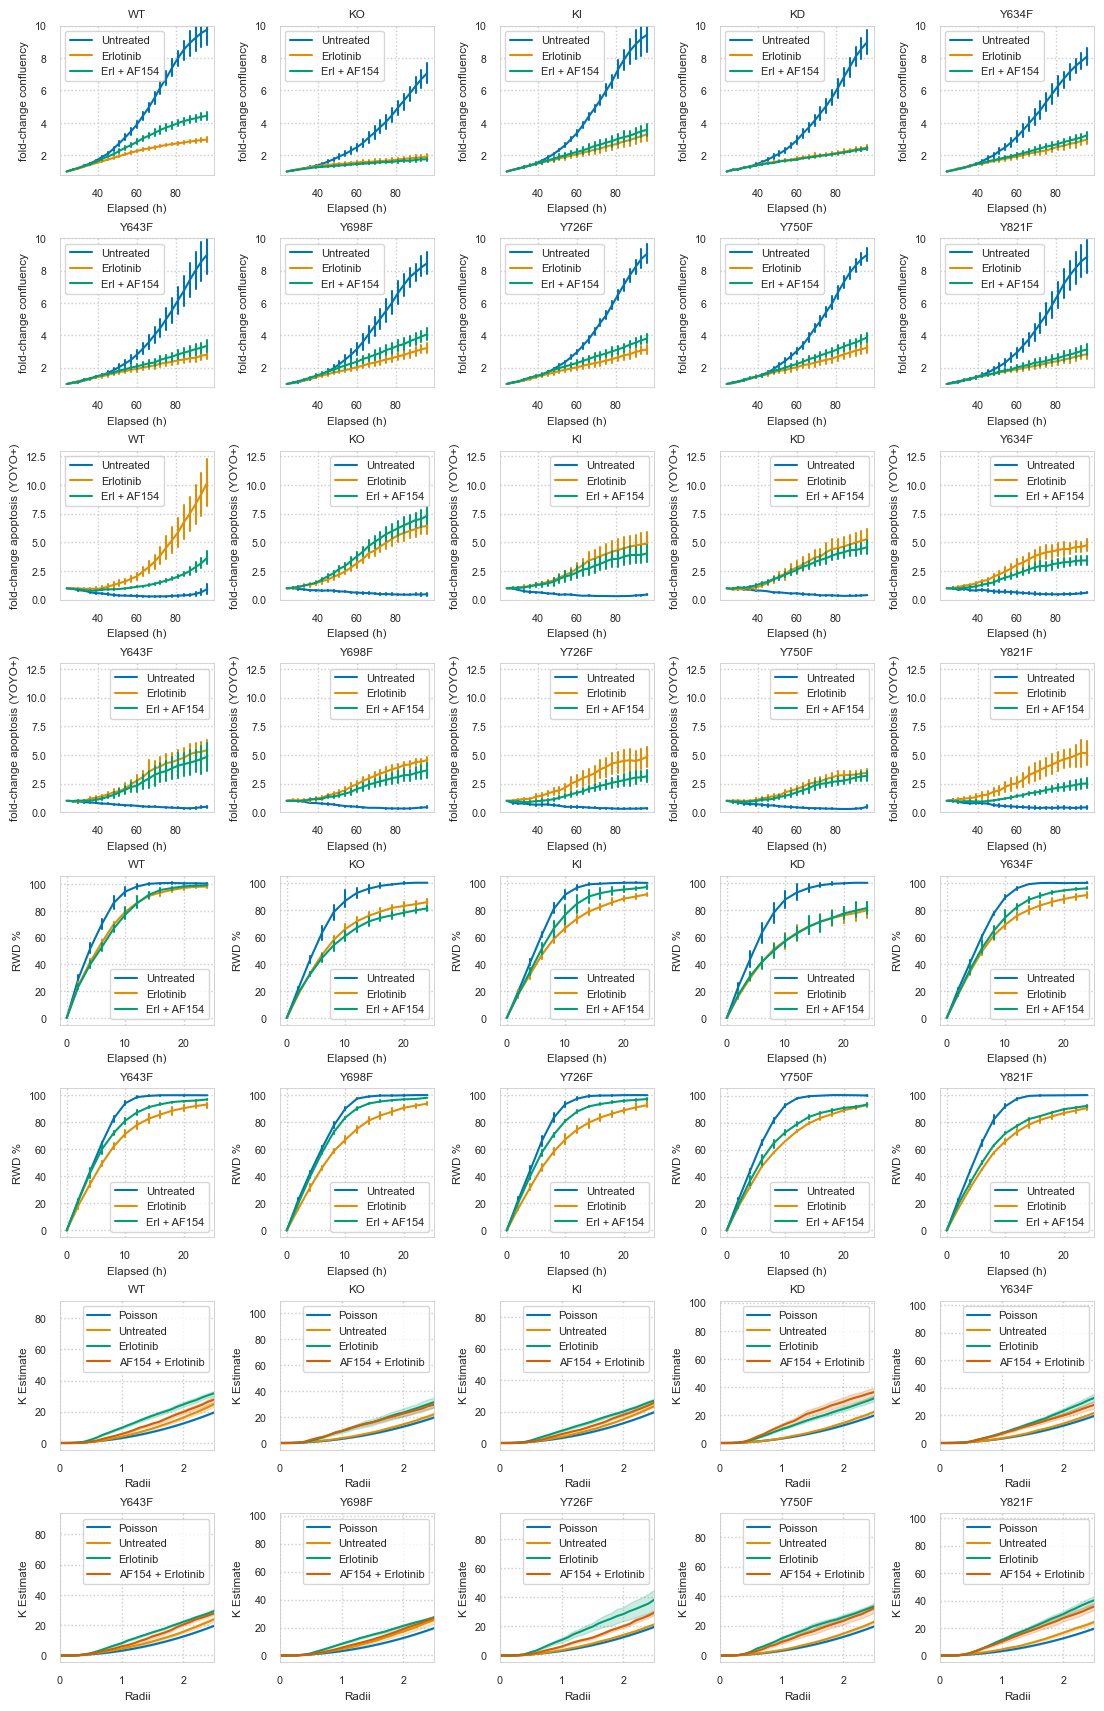

In [4]:
lines = ["WT", "KO", "KI", "KD", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F", "Y821F"]
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
tr1 = ["-UT", "-E", "-A/E"]
tr2 = ["Untreated", "Erlotinib", "Erl + AF154"]
cv = import_phenotype_data(phenotype="Cell Viability")
red = import_phenotype_data(phenotype="Cell Death")
sw = import_phenotype_data(phenotype="Migration")
ax, f = getSetup((11, 17), (8, 5))
cv_f, red_f, sw_f, ci_f = [], [], [], []
for i, line in enumerate(lines):
    cv_c = IndividualTimeCourses(cv, 96, lines, tr1, tr2, "fold-change confluency", TimePointFC=24, TreatmentFC=False, plot=line, ax_=ax[i], ylim=[0.8, 10], out=True)
    cv_c["Lines"] = line
    cv_f.append(cv_c)
    red_c = IndividualTimeCourses(red, 96, lines, tr1, tr2, "fold-change apoptosis (YOYO+)", TimePointFC=24, plot=line, ax_=ax[i + 10], ylim=[0, 13], out=True)
    red_c["Lines"] = line
    red_f.append(red_c)
    sw_c = IndividualTimeCourses(sw, 24, lines, tr1, tr2, "RWD %", plot=line, ax_=ax[i + 20], out=True)
    sw_c["Lines"] = line
    sw_f.append(sw_c)
    ci_c = PlotRipleysK('48hrs', mutants[i], ['ut', 'e', 'ae'], 6, ax=ax[i + 30], title=line, out=True)
    ci_c["Lines"] = line
    ci_f.append(ci_c)

In [6]:
cvF = pd.concat(cv_f).rename(columns={"fold-change confluency":"Data"})
redF = pd.concat(red_f).rename(columns={"fold-change apoptosis (YOYO+)":"Data"})
swF = pd.concat(sw_f).rename(columns={"RWD %":"Data"})
ciF = pd.concat(ci_f).rename(columns={"Condition":"Treatments", "K Estimate":"Data"})
ciF["Treatments"] = ciF["Treatments"].replace("AF154 + Erlotinib", "Erl + AF154")

In [11]:
from scipy.stats import mannwhitneyu

ds = [cvF, redF, swF, ciF]
dsL = ["Cell Viability", "Apoptosis", "Migration", "Island"]

df = pd.DataFrame()
pvals = []
lines = []
phe = []
for ii, d in enumerate(ds):
    for l in list(set(d["Lines"])):
        cl = d[d["Lines"] == l]
        c_erl = cl[cl["Treatments"] == "Erlotinib"].loc[:, "Data"].values
        c_ea = cl[cl["Treatments"] == "Erl + AF154"].loc[:, "Data"].values
        pvals.append(mannwhitneyu(c_erl, c_ea)[1])
        lines.append(l)
        phe.append(dsL[ii])

df["Cell Line"] = lines
df["Phenotype"] = phe
df["p-value"] = pvals


In [12]:
df

,Cell Line,Phenotype,p-value
0,KI,Cell Viability,0.276346
1,KD,Cell Viability,0.789038
2,Y821F,Cell Viability,0.406789
3,Y726F,Cell Viability,0.028839
4,Y750F,Cell Viability,0.093457
5,Y698F,Cell Viability,0.019814
6,WT,Cell Viability,0.000152
7,Y643F,Cell Viability,0.123413
8,KO,Cell Viability,0.089699
9,Y634F,Cell Viability,0.245289


In [17]:
def fold_change_acrossBRs(data, itp):
    """Compute fold change to initial time point in every BR.
    Note that data should always be a list, even if just one BR."""
    new = []
    for i, mat in enumerate(data):
        new.append(TimePointFoldChange(mat, itp))
    return new

def TimePointFoldChange(d, itp):
    """ Take fold-change of the time lapse data set to an initial time point  """
    for jj in range(1, d.columns.size):
        d.iloc[:, jj] /= d[d["Elapsed"] == itp].iloc[0, jj]
    return d

def transform_DRviability(data, units, itp, survival_plot=True):
    """Transform to initial time point and convert into seaborn format"""
    new = fold_change_acrossBRs(data, itp)
    c = pd.concat(new, axis=0)
    c = pd.melt(c, id_vars="Elapsed", value_vars=c.columns[1:], var_name="Lines", value_name="% Survival (Relative to UT)")
    c["Treatment"] = [s.split(" ")[1].split(" ")[0] for s in c["Lines"]]
    c["Inh_concentration"] = [s[4:].split(" ")[1] for s in c["Lines"]]
    c["Lines"] = [s.split(" ")[0] for s in c["Lines"]]
    c = c[["Elapsed", "Lines", "Treatment", "Inh_concentration", "% Survival (Relative to UT)"]]
    c = c[c["Elapsed"] >= itp]
    c.insert(0, "IC_n", [float(s.split(units)[0]) for s in c["Inh_concentration"]])

    if survival_plot:
        cls = []
        for line in list(set(c["Lines"])):
            l_ut = c[(c["Lines"] == "WT") & (c["Treatment"] == "UT") & (c["Inh_concentration"] == "0" + units)].sort_values(by="Elapsed")
            l = c[c["Lines"] == line]
            l.index = np.arange(l.shape[0])
            for treatment in list(set(l["Treatment"])):
                for conc in list(set(l["Inh_concentration"])):
                    curr_idx = l[(l["Treatment"] == treatment) & (l["Inh_concentration"] == conc)].sort_values(by="Elapsed").index
                    l.iloc[curr_idx, -1] /= l_ut.iloc[:, -1].values
                    l.iloc[curr_idx, -1] *= 100
            cls.append(l)
        return pd.concat(cls).sort_values(by="IC_n").drop("IC_n", axis=1)
    
    else:
        return c.sort_values(by="IC_n").drop("IC_n", axis=1)

def merge_TRs(filename, nTRs):
    """Merge technical replicates of an experiment"""
    path = "msresist/data/Validations/CellGrowth/"
    inh = pd.read_csv(path + filename)
    # for i in range(1, nTRs):
    inh.columns = [col.split(".1")[0].strip() for col in inh.columns]
    inh = inh.groupby(lambda x: x, axis=1).mean()
    return inh

def plot_InhDR_timepoint(ax, inhibitor, time, cl="WT", itp=24, out=False, survival_plot=True, title=False):
    """Plot inhibitor DR at specified time point."""
    if inhibitor == "Dasatinib":
        inh = [merge_TRs("Das_BR3_fixed.csv", 2), merge_TRs("Dasatinib_2fixed.csv", 2)]
        units = "nM"
    elif inhibitor == "CX-4945":
        inh = [merge_TRs("CX_4945_BR1_dose.csv", 2), merge_TRs("02032022-CX_4945_BR3_dose.csv", 2)]
        units = "uM"
    elif inhibitor == "Volasertib":
        inh = [merge_TRs("Volasertib_Dose_BR1.csv", 2), merge_TRs("Volasertib_Dose_BR2.csv", 2)]
        units = "nM"
    data = transform_DRviability(inh, units, itp, survival_plot=survival_plot)
    if out:
        return data
    tp = data[data["Elapsed"] == time]
    tp = tp[tp["Lines"] == cl]
    # order = ["UT", "E/A", "E", "E/R"]
    order = ["UT", "EA", "E"]
    sns.barplot(data=tp, x="Inh_concentration", y="% Survival (Relative to UT)", hue="Treatment", hue_order=order, errorbar=('ci', 68), ax=ax)
    # box_pairs=[
    # (("0nM", "E"), ("0nM", "E/A")),
    # (("1.6nM", "E"), ("1.6nM", "E/A")),
    # (("8nM", "E"), ("8nM", "E/A")),
    # (("40nM", "E"), ("40nM", "E/A")),
    # (("200nM", "E"), ("200nM", "E/A")),
    # (("1000nM", "E"), ("1000nM", "E/A")),
    # ]
    box_pairs=[
        (("0uM", "EA"), ("0uM", "E")),
        (("0.5uM", "EA"), ("0.5uM", "E")),
        (("1uM", "EA"), ("1uM", "E")),
        (("2uM", "EA"), ("2uM", "E")),
        (("4uM", "EA"), ("4uM", "E")),
        (("8uM", "EA"), ("8uM", "E")),
        (("16uM", "EA"), ("16uM", "E")),
        (("32uM", "EA"), ("32uM", "E")),
    ]
    annotate_pvals(ax, tp, "Inh_concentration", "% Survival (Relative to UT)", box_pairs, hue="Treatment", loc="inside")
    ax.set_xlabel(inhibitor + " Concentration")
    if title:
        ax.set_title(title)

import statannot
def annotate_pvals(ax, df, x, y, box_pairs, hue, loc="outside"):
    statannot.add_stat_annotation(
        ax=ax, 
        data=df, 
        x=x, 
        y=y, 
        hue=hue, 
        box_pairs=box_pairs, 
        test="Mann-Whitney", 
        text_format="star", 
        loc=loc,
        verbose=False)


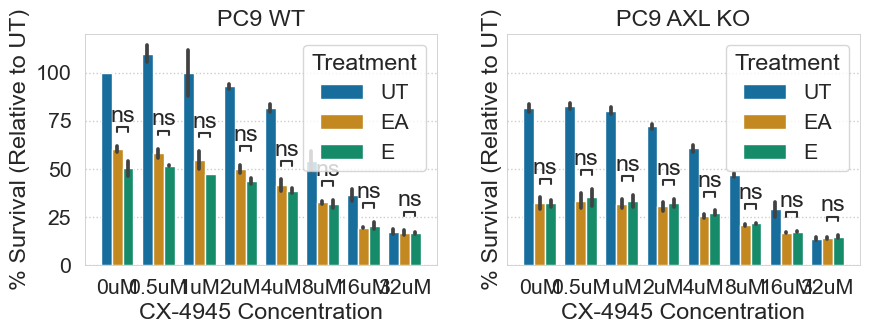

In [22]:
_, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plot_InhDR_timepoint(ax[0], "CX-4945", 72, cl="WT", itp=21, title="PC9 WT")
plot_InhDR_timepoint(ax[1], "CX-4945", 72, cl="KO", itp=21, title="PC9 AXL KO")
plt.savefig("CX-4945.svg")

<AxesSubplot: xlabel='Elapsed', ylabel='% Survival (Relative to UT)'>

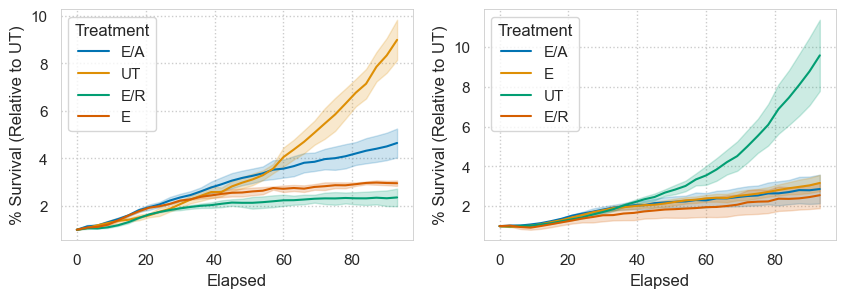

In [12]:
out_das = plot_InhDR_timepoint(ax[1], "Dasatinib", 96, cl="KO", itp=0, out=True, survival_plot=False)
d200 = out_das[(out_das["Inh_concentration"] == "40nM") & (out_das["Elapsed"] < 96)]

_, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=False)
sns.lineplot(d200[d200["Lines"] == "WT"], x="Elapsed", y="% Survival (Relative to UT)", hue="Treatment", errorbar=('ci', 63), ax=ax[0])
sns.lineplot(d200[d200["Lines"] == "KO"], x="Elapsed", y="% Survival (Relative to UT)", hue="Treatment", errorbar=('ci', 63), ax=ax[1])

<AxesSubplot: xlabel='Elapsed', ylabel='% Survival (Relative to UT)'>

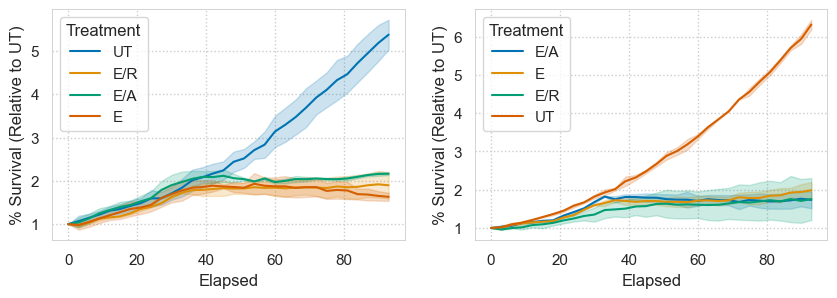

In [11]:
out_das = plot_InhDR_timepoint(ax[1], "Dasatinib", 96, cl="KO", itp=0, out=True, survival_plot=False)
d200 = out_das[(out_das["Inh_concentration"] == "200nM") & (out_das["Elapsed"] < 96)]

_, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=False)
sns.lineplot(d200[d200["Lines"] == "WT"], x="Elapsed", y="% Survival (Relative to UT)", hue="Treatment", errorbar=('ci', 63), ax=ax[0])
sns.lineplot(d200[d200["Lines"] == "KO"], x="Elapsed", y="% Survival (Relative to UT)", hue="Treatment", errorbar=('ci', 63), ax=ax[1])

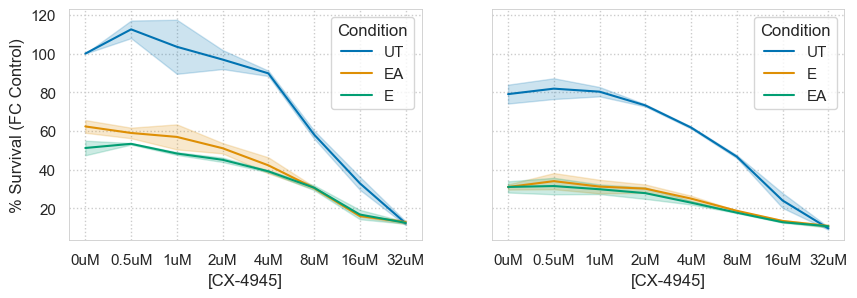

In [15]:
 _, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
phlot_InhDR_timepoint(ax[0], "CX-4945", 72, cl="WT", itp=12)
plot_InhDR_timepoint(ax[1], "CX-4945", 72, cl="KO", itp=12)

<AxesSubplot: xlabel='Elapsed', ylabel='% Survival (FC Control)'>

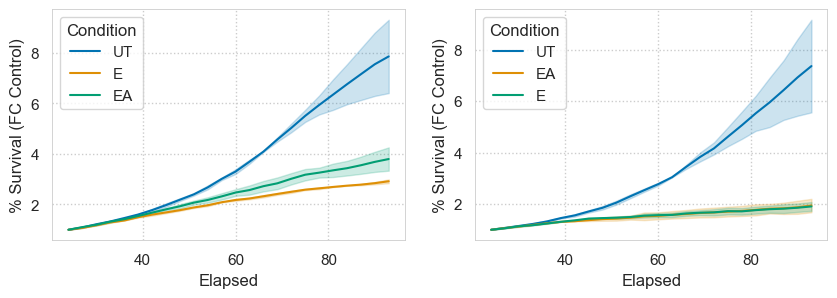

In [86]:
out_das = plot_InhDR_timepoint(ax[1], "CX-4945", 96, cl="KO", itp=24, out=True, survival_plot=False)
d200 = out_das[(out_das["Inh_concentration"] == "0uM") & (out_das["Elapsed"] < 96)]

_, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=False)
sns.lineplot(d200[d200["Lines"] == "WT"], x="Elapsed", y="% Survival (Relative to UT)", hue="Treatment", errorbar=('ci', 68), ax=ax[0])
sns.lineplot(d200[d200["Lines"] == "KO"], x="Elapsed", y="% Survival (Relative to UT)", hue="Treatment", errorbar=('ci', 68), ax=ax[1])

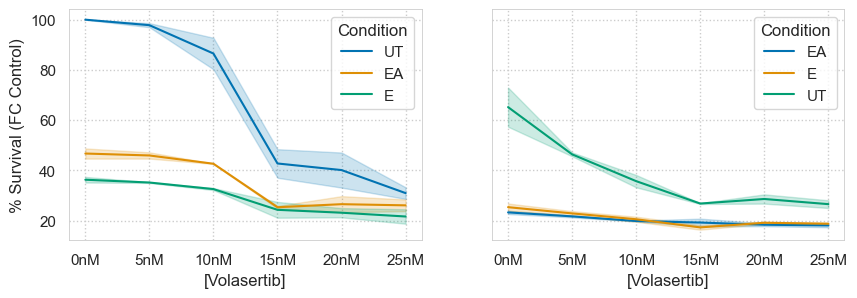

In [87]:
_, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plot_InhDR_timepoint(ax[0], "Volasertib", 72, cl="WT", itp=21)
plot_InhDR_timepoint(ax[1], "Volasertib", 72, cl="KO", itp=21)